### Import

In [15]:
import gzip
import json
import random
import time
from nltk import word_tokenize
from tqdm import tqdm
import contractions

# Imports for the synonym dictionary 
import requests
from bs4 import BeautifulSoup
from nltk.wsd import lesk

#wordnet imports
#importing NLTK corpus synonym dictionary, pos-tagging and checking the outputs
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
import random
from sklearn.pipeline import Pipeline

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

#Word2Vec imports
import gensim.models

In [16]:
#wordnet downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
random.seed(42)

### Read in the data

In [18]:
#here
def reading_in(path):
    thing=[]
    for line in gzip.open(path):
        review_data = json.loads(line)
        subthing = dict()
        for key in review_data:
            subthing[key]= review_data[key]
        thing.append(subthing)
    return thing

In [19]:
train = reading_in('../data/classification/music_reviews_train.json.gz')
dev = reading_in('../data/classification/music_reviews_dev.json.gz') # do not use!
#test = reading_in('../data/classification/music_reviews_test_masked.json.gz') #do not use!
train = shuffle(train, random_state=42)

In [20]:
train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

dev_x = [i['reviewText'] if "reviewText" in i.keys() else "" for i in dev]
dev_y = [i['sentiment'] for i in dev]

In [21]:
pos_neg = [sum([i =="positive" for i in train_y]),sum([i != "positive" for i in train_y])]

<BarContainer object of 2 artists>

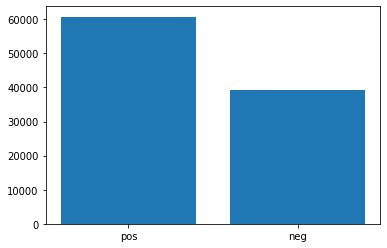

In [22]:
import matplotlib.pyplot as plt
plt.bar(x=["pos","neg"], height = pos_neg) 

In [23]:
###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train = train_x_neg
balanced_y_train = train_y_neg

In [9]:
len(balanced_x_train)

78424

In [ ]:
len(train_x_neg)

NameError: name 'train_x_neg' is not defined

### Preparing the data

In [24]:
#old tokenizer
#train_x_back = [' '.join(sen) for sen in train_x_split] may not need convertes tokenised back to single string

In [25]:
#Tokenizer
def tokenize_corpus(corpus):
    return [word_tokenize(contractions.fix(s)) for s in corpus]

In [26]:
train_x_split = tokenize_corpus(balanced_x_train)

# Webscrape synonyms

In [ ]:
##Alternative to PyDictionary
##THIS IS COPIED FROM SLACK
# https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api

def synonyms(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms

word = "us"
print(synonyms(word))

['them ', 'you ']


In [ ]:
dont_replace = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will','I ', 'it ', 'she ', 'sie ', 'they ', 've ', 'xe ', 'you ', 'ze ', 'zie ','he',"you","we","mine","hers","his","yours","its","ours","theirs","your","our","oneself","oneselves","yourself","yourselves","himself","herself","himself","myself","themselves","itself","ourselves","ourself","us","them"] #Used to avoid changing function and pronouns words
random.seed(43)
def gen_synth_web(sentence,prob = 0.5):
    new_sen = []
    for word in sentence:
        if word in dont_replace:
            new_sen.append(word)
        else:
            threshold = random.random()
            if prob > threshold:
                #print(threshold) can remove later kept for debugging
                syn = synonyms(word)
                if len(syn) != 0:
                    #print("selected", word) can remove later kept for debugging
                    new_sen.append(random.choice(syn))
                else:new_sen.append(word)
            else:
                new_sen.append(word)
    return new_sen

In [ ]:
print(train_x_split[12])

NameError: name 'train_x_split' is not defined

In [ ]:
print(gen_synth_web(train_x_split[12]))

NameError: name 'gen_synth_web' is not defined

In [ ]:
#for i in tqdm(train_x_split[:1000]):#running with 0:1000 dont uncomment as will mess up file 
   # with open ("../data/synthetic1.txt","a") as f:
       # f.write(' '.join(gen_synth_web(i))+"\n")
       # time.sleep(3)

  1%|▏         | 13/1000 [01:18<1:39:39,  6.06s/it]


KeyboardInterrupt: 

#### Example of webscrape synthetic sentence 

In [ ]:
print(train_x_split[6])

['I', 'love', 'all', 'of', 'his', 'music', '!', '!']


In [ ]:
print(gen_synth_web(train_x_split[6]))

['I', 'passion ', 'fully ', 'of', 'his', 'music', '!', '!']


# Wordnet

In [57]:
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
wordnet_tag_map = {'NN': ['n'],'NNS': ['n'],'JJ': ['a'],'JJR': ['a'],'JJS': ['a'],'RB': ['r'],'RBR': ['r'],'RBS': ['r'], 'VB': ['v'], 'VBG': ['v'], 'VBD': ['v'], 'VBN': ['v'], 'VBP': ['v'], 'VBZ': ['v']} #Making pos-tags coincide
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_wordnet(sentence):
    sentence = nltk.pos_tag(sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if random.random()>0.5:
            if word[1] in relevant and word[0] not in aux_verbs: #Not changing functional words
                tag = wordnet_tag_map[word[1]]
                chosen = lesk(sentence, word[0], tag[0]) #from all synsets choose the most likely in a smart way, thanks to library!
                if chosen is None:
                    new_sentence.append(word[0]) #sometimes no synset is chosen so we just give the new sentence the original word
                else:
                    options = chosen.lemma_names()
                    if word[0] in options:
                        options.remove(word[0])
                    if len(options)>0:
                        chosen_w = random.choice(options)
                        if "_" in chosen_w:
                            for w in chosen_w.split("_"):
                                new_sentence.append(w)
                        else:
                            new_sentence.append(chosen_w)
                    else:
                        new_sentence.append(word[0])
            else:
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

#### Example of wordnet synthetic sentence 

In [62]:
print(train_x_split[2])

['will', 'not', 'play', 'on', 'any', 'MP3', 'device', 'will', 'play', 'on', 'my', 'computer']


In [68]:
print(change_wordnet(train_x_split[2]))

['will', 'non', 'play', 'on', 'any', 'MP3', 'device', 'will', 'play', 'on', 'my', 'computing', 'machine']


#### write to file

In [69]:
wn_x_train = [change_wordnet(i) for i in train_x_split]

In [70]:
len(wn_x_train)

78424

In [71]:
with open("../data/synthetic/wordnet.csv",'w') as f:
    f.writelines('\t'.join(s) + '\n' for s in wn_x_train)

# Word2vec

In [ ]:
gooEmbs.most_similar('walk')

[('walking', 0.7361534237861633),
 ('walks', 0.7007260918617249),
 ('walked', 0.6831838488578796),
 ('stroll', 0.6208134889602661),
 ('Walking', 0.5674901604652405),
 ('Walk', 0.558607280254364),
 ('wander', 0.5585978627204895),
 ('jog', 0.5467169284820557),
 ('saunter', 0.5451485514640808),
 ('amble', 0.5250112414360046)]

In [37]:
# With a threshold and without the check of same word

gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-50k.bin', binary=True)
print('loading finished')
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_word2vec(original_sentence, prob = 0.5, threshold = .6):
    sentence = nltk.pos_tag(original_sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if word[1] in relevant and word[0] not in aux_verbs:
            if random.random() > prob:
                try:
                    syno = gooEmbs.most_similar(word[0]) #taking the most similar word from word2vec
                    syno_pos = []
                    # method 1: 
                    for s in syno:
                        if s[1] > threshold:
                            syno_pos.append(s)
                        else: 
                            break # because all the words are sorted we know that if one word is under 60% all the others after are also
                    if syno_pos!=[]:
                        new_word = random.choice(syno_pos)[0]
                    else:  new_word = syno[0][0]
                    if "_" in new_word:
                        for w in chosen_w.split("_"):
                            new_sentence.append(w)
                    else: new_sentence.append(new_word)                    
                except:
                    new_sentence.append(word[0])
            else: 
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

loading finished


In [38]:
ori = train_x_split[3]
t7= change_word2vec(train_x_split[3], threshold=0.7)
t6 =change_word2vec(train_x_split[3], threshold=0.6)
t5 = change_word2vec(train_x_split[3], threshold=0.5)
t4 = change_word2vec(train_x_split[3], threshold=0.4)
t3 = change_word2vec(train_x_split[3], threshold=0.3)

for i in range(len(ori)):
    print(f'o: {ori[i]}, .7: {t7[i]}, .6: {t6[i]}, .5: {t5[i]}, .4 {t4[i]}, .3: {t3[i]}')

empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
o: Nickleback, .7: Nickleback, .6: Nickleback, .5: Nickleback, .4 Nickleback, .3: Nickleback
o: is, .7: is, .6: is, .5: is, .4 is, .3: is
o: Clear, .7: Clean, .6: Clean, .5: Clean, .4 Clean, .3: Clean
o: Channel, .7: Channel, .6: Channel, .5: Channel, .4 Channel, .3: Channel
o: 's, .7: 's, .6: 's, .5: 's, .4 's, .3: 's
o: best, .7: finest, .6: finest, .5: healthiest, .4 good, .3: good
o: friend, .7: friends, .6: acquaintance, .5: cousin, .4 buddy, .3: friends
o: :, .7: :, .6: :, .5: :, .4 :, .3: :
o: their, .7: their, .6: their, .5: their, .4 their, .3: their
o: music, .7: classical_music, .6: musics, .5: reggae, .4 musicians, .3: reggae
o: is, .7: is, .6: is, .5: is, .4 is, .3: is
o: ordinary, .7: Ordinary, 

In [29]:
print(ori)
print(t7)
print(t6)
print(t5)
print(t4)
print(t3)

['Nickleback', 'is', 'Clear', 'Channel', "'s", 'best', 'friend', ':', 'their', 'music', 'is', 'ordinary', ',', 'dull', ',', 'and', 'absolutely', 'defining', 'mainstream', '.', 'The', 'songs', 'here', 'are', 'all', 'the', 'same', ',', 'with', 'poor', 'lyrics', ',', 'and', 'Chad', "'s", 'standard', ',', 'ordinary', 'singing', 'style', '.', 'Sorry', 'about', 'using', 'ordinary', 'so', 'many', 'times', ',', 'it', 'just', 'defines', 'this', 'band', 'so', 'well', '.', 'I', 'find', 'it', 'hilarious', 'that', '``', 'A', 'kid', "'s", 'review', "''", 'was', 'chosen', 'as', 'a', 'spotlight', 'review', ',', 'because', 'he/she', 'defines', 'the', 'average', 'radio-listening', ',', 'Nickleback', 'fan', '.', 'What', 'I', 'hate', 'about', 'bands', 'like', 'this', 'is', 'that', 'they', 'take', 'away', 'radio', 'time', 'to', 'expose', 'bands', 'that', 'deserve', 'our', 'attention', '.', 'Anybody', 'with', 'brains', 'should', 'turn', 'this', 'off', 'and', 'listen', 'to', 'real', 'talent', 'like', 'In', '

In [ ]:
#new_x = []
#for  i in train_x[:1000]:
    #new_x.append(change_word2vec(i))

In [ ]:
print(train_x_split[6])
print(gen_synth_web(train_x_split[6]))
print(change_wordnet(train_x_split[6]))
print(change_word2vec(train_x_split[6]))

['I', 'love', 'all', 'of', 'his', 'music', '!', '!']
['ve ', 'love', 'group ', 'of', 'his', 'music', '!', '!']
['I', 'have_intercourse', 'all', 'of', 'his', 'music', '!', '!']


UnboundLocalError: local variable 'sentence' referenced before assignment

In [ ]:
 gooEmbs.most_similar('woman')

[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.6317085027694702),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975907444953918),
 ('Woman', 0.5770983099937439)]

# Baseline

In [ ]:
pipeline = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(1, 2))),
    ('Tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])

In [ ]:
size = [500, 1000, 2500, 5000, 10000, 20000, 30000, 50000, 60000, 70000, 80000, 90000, 100000]
train_acc = []
dev_acc = []
for i in size:
    pipeline.fit(balanced_x_train[:i],balanced_y_train[:i] )
    pred_train = pipeline.predict(balanced_x_train)
    train_acc.append(f1_score(balanced_x_train, pred_train, average='macro'))
    pred = pipeline.predict(dev_x)
    dev_acc.append(f1_score(dev_y, pred, average='macro'))
    print(f'done with size {i}')


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
plt.plot(size, dev_acc)

In [ ]:
plt.plot(size, train_acc)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b88dfe01-c7e1-473c-bcfd-798313fc6522' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>